# Crime Analyzer — General — Final Data Consolidation & Validation

Purpose
- Validate the feature-engineered dataset with comprehensive quality checks
- Export final CSV artifacts and metadata for modeling and visualization

Inputs
- JupyterOutputs/FeatureEngineered/feature_engineered_crime_data.csv (fallback: ..._enhanced.csv)

Outputs
- JupyterOutputs/Final/final_crime_data.csv (+ optional .gz if >100MB)
- JupyterOutputs/Final/final_dataset_metadata.json
- Optional sample: JupyterOutputs/Final/final_crime_data_sample_10000.csv

## Import Libraries

Import all necessary libraries for data manipulation and visualization.

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import json
from datetime import datetime
from collections import Counter
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

## Paths

Write outputs under JupyterOutputs/Final to keep notebooks stateless and friendly for CI/CD artifact collection. Adjust base_dir if executing from a different working directory.

In [9]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
feature_engineering_dir = os.path.join(base_dir, "FeatureEngineered")
feature_engineered_file_path = os.path.join(feature_engineering_dir, "feature_engineered_crime_data.csv")
final_dir = os.path.join(base_dir, "Final")
os.makedirs(final_dir, exist_ok=True)

# Load feature-engineered data

We attempt the primary artifact and fall back to the enhanced variant. We print shape and memory, then continue only if basic expectations are met.

In [10]:
# Load the feature engineered dataset
print("=== Loading Feature Engineered Data ===")
try:
    if os.path.exists(feature_engineered_file_path):
        df = pd.read_csv(feature_engineered_file_path)
        initial_rows = len(df)
        print(f"Dataset loaded successfully: {initial_rows} rows and {df.shape[1]} columns")
        print(f"Columns in the dataset: {df.columns.tolist()}")

        # Basic validation
        if initial_rows == 0:
            raise ValueError("Feature engineered dataset is empty")
        if df.shape[1] < 10:
            raise ValueError("Feature engineered dataset has too few columns")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise RuntimeError(f"Failed to load feature engineered dataset: {e}")

# Display basic dataset info
print(f"\n=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Data types: {df.dtypes.value_counts().to_dict()}")

=== Loading Feature Engineered Data ===
Dataset loaded successfully: 2496742 rows and 44 columns
Columns in the dataset: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY', 'SAME_AGE_GROUP', 'SAME_SEX', 'TO_CHECK_CITIZENS']

=== Dataset Overview ===
Shape: (2496742, 44)
Dataset loaded successfully: 2496742 rows and 44 columns
Columns in the dataset: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUS

# Dataset quality and completeness assessment

We baseline the dataset with missing values, duplicates, dtypes, cardinality, numerical ranges/inf, categorical samples. These checks explain model readiness and common pitfalls (e.g., leakage via IDs, high cardinality).

In [11]:
print("\n=== COMPREHENSIVE DATASET QUALITY ASSESSMENT ===")

# Missing Value Analysis
print("\n--- Missing Values Analysis ---")
missing_summary = df.isnull().sum()
missing_columns = missing_summary[missing_summary > 0]

if len(missing_columns) > 0:
    print("Columns with missing values:")
    for col, count in missing_columns.items():
        percentage = (count / len(df)) * 100
        print(f"  {col}: {count} ({percentage:.2f}%)")

    total_missing = missing_summary.sum()
    total_cells = len(df) * len(df.columns)
    overall_missing_pct = (total_missing / total_cells) * 100
    print(f"\nOverall missing data: {total_missing}/{total_cells} ({overall_missing_pct:.2f}%)")
else:
    print("No missing values found")

# Duplicate Analysis
print("\n--- Duplicate Records Analysis ---")
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate rows ({num_duplicates/len(df)*100:.2f}%)")
    df.drop_duplicates(inplace=True)
    print(f"Shape after removing duplicates: {df.shape}")
else:
    print("No duplicate rows found")

# Data Type Consistency
print("\n--- Data Type Distribution ---")
type_counts = df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"  {dtype}: {count} columns")

# Cardinality Analysis
print("\n--- Cardinality Analysis (Top 10 Highest) ---")
cardinality = df.nunique().sort_values(ascending=False)
high_cardinality_threshold = len(df) * 0.8  # More than 80% unique values

for i, (col, unique_count) in enumerate(cardinality.head(10).items()):
    percentage = (unique_count / len(df)) * 100
    print(f"  {col}: {unique_count} unique ({percentage:.1f}%)")

# Numerical Features Analysis
print("\n--- Numerical Features Analysis ---")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(f"Number of numerical columns: {len(numeric_cols)}")

    # Check for potential outliers and ranges
    numeric_stats = df[numeric_cols].describe()
    print("\nNumerical statistics summary:")
    print(numeric_stats.loc[['min', 'max', 'mean', 'std']].round(3))

    # Check for infinite values
    infinite_cols = []
    for col in numeric_cols:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            infinite_cols.append((col, inf_count))

    if infinite_cols:
        print(f"\nColumns with infinite values:")
        for col, count in infinite_cols:
            print(f"  {col}: {count} infinite values")
    else:
        print(f"\nNo infinite values found in numerical columns")

else:
    print("No numerical columns found")

# Categorical Features Analysis
print("\n--- Categorical Features Analysis ---")
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Number of categorical columns: {len(categorical_cols)}")

    # Show sample values for each categorical column
    for col in categorical_cols[:5]:  # Show first 5 categorical columns
        unique_vals = df[col].unique()
        print(f"\n{col} ({len(unique_vals)} unique values):")
        if len(unique_vals) <= 10:
            print(f"  Values: {list(unique_vals)}")
        else:
            print(f"  Sample values: {list(unique_vals[:10])}...")
else:
    print("No categorical columns found")



=== COMPREHENSIVE DATASET QUALITY ASSESSMENT ===

--- Missing Values Analysis ---
No missing values found

--- Duplicate Records Analysis ---
No missing values found

--- Duplicate Records Analysis ---
Found 2907 duplicate rows (0.12%)
Found 2907 duplicate rows (0.12%)
Shape after removing duplicates: (2493835, 44)

--- Data Type Distribution ---
  float64: 17 columns
  object: 14 columns
  int64: 13 columns

--- Cardinality Analysis (Top 10 Highest) ---
Shape after removing duplicates: (2493835, 44)

--- Data Type Distribution ---
  float64: 17 columns
  object: 14 columns
  int64: 13 columns

--- Cardinality Analysis (Top 10 Highest) ---
  MAX_POI_DISTANCE: 133525 unique (5.4%)
  ATM_DISTANCE: 133525 unique (5.4%)
  NIGHTCLUB_DISTANCE: 133525 unique (5.4%)
  BAR_DISTANCE: 133525 unique (5.4%)
  MIN_POI_DISTANCE: 133525 unique (5.4%)
  AVG_POI_DISTANCE: 133525 unique (5.4%)
  METRO_DISTANCE: 133525 unique (5.4%)
  Longitude: 125443 unique (5.0%)
  Latitude: 124278 unique (5.0%)
  PD_

## Chi-square associations (categorical)

We compute pairwise chi-square tests between categorical variables and visualize associations.
On very large datasets, p-values often collapse to ~0 even for weak effects. To make results actionable, we:
- Cap the number of categories per variable and group rare levels into "Other"
- Optionally subsample rows for the test to control N-driven significance
- Report Cramer's V effect sizes alongside p-values (effect size is much more informative for large N)

This information can help identify redundancy between attributes and guide feature selection.

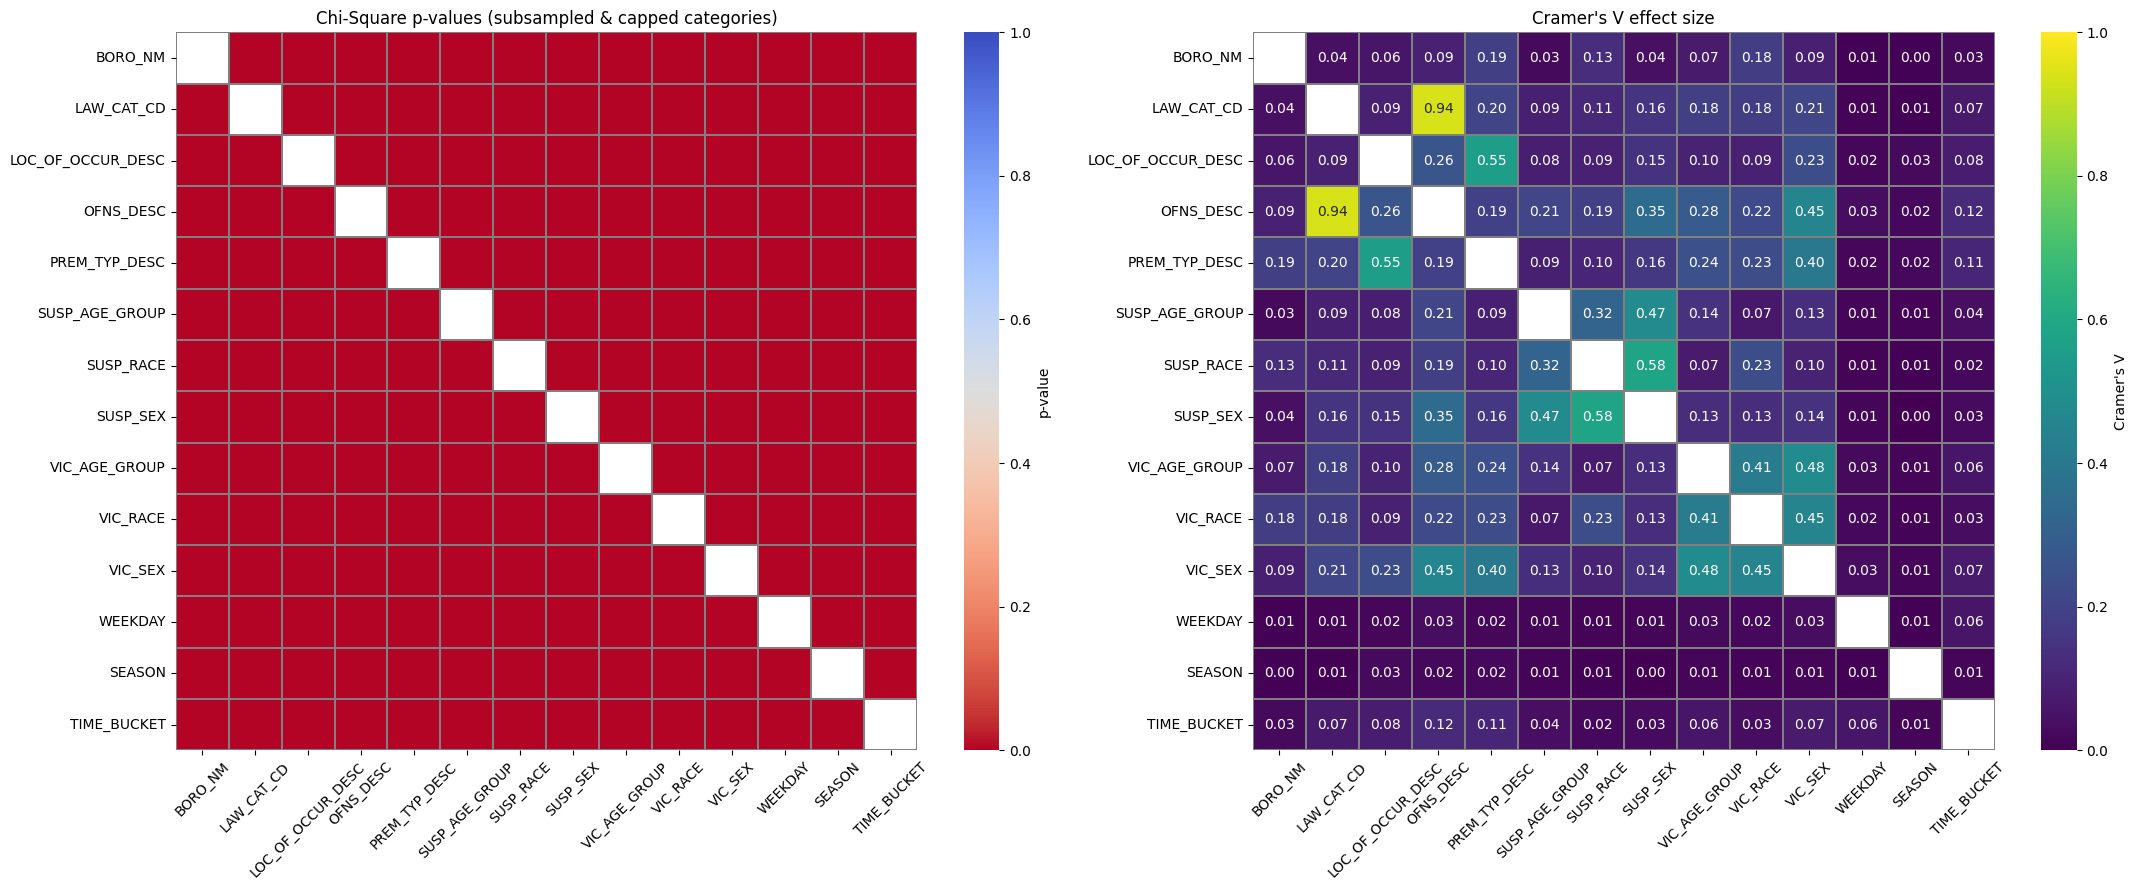

Top categorical associations by Cramer's V:
       Variable 1    Variable 2  CramersV
       LAW_CAT_CD     OFNS_DESC  0.937587
        SUSP_RACE      SUSP_SEX  0.584653
LOC_OF_OCCUR_DESC PREM_TYP_DESC  0.553809
    VIC_AGE_GROUP       VIC_SEX  0.477106
   SUSP_AGE_GROUP      SUSP_SEX  0.474021
        OFNS_DESC       VIC_SEX  0.453217
         VIC_RACE       VIC_SEX  0.450579
    VIC_AGE_GROUP      VIC_RACE  0.414087
    PREM_TYP_DESC       VIC_SEX  0.401194
        OFNS_DESC      SUSP_SEX  0.347255


In [12]:
# Configurable controls to mitigate p-values collapsing to ~0 on large N
MAX_CATEGORIES = 20          # cap categories per variable (others -> 'Other')
MIN_FREQ_PCT = 0.01          # categories with <1% freq are grouped into 'Other'

# Helper: bucket rare categories and cap the number of levels
def sanitize_categories(series: pd.Series,
                        max_categories: int = MAX_CATEGORIES,
                        min_freq_pct: float = MIN_FREQ_PCT) -> pd.Series:
    s = series.astype("string").fillna("<NA>")
    counts = s.value_counts(dropna=False)
    total = len(s)
    # Group rare levels
    rare = counts[counts / total < min_freq_pct].index
    s = s.where(~s.isin(rare), other="Other")
    # Cap top categories
    top = s.value_counts(dropna=False).head(max_categories).index
    s = s.where(s.isin(top), other="Other")
    return s

# Helper: compute Cramer's V from a contingency table
def cramers_v(confusion_matrix: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias-corrected Cramer's V
    phi2corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1)) if n > 1 else np.nan
    rcorr = r - (r - 1) ** 2 / (n - 1) if n > 1 else np.nan
    kcorr = k - (k - 1) ** 2 / (n - 1) if n > 1 else np.nan
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0 or np.isnan(denom):
        return np.nan
    return np.sqrt(phi2corr / denom)

df_cat = df

# Get categorical columns (incl. category/bool)
categorical_cols = df_cat.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

chi2_summary = []

# Perform pairwise chi-square tests with sanitized categories
for i in range(len(categorical_cols)):
    for j in range(i + 1, len(categorical_cols)):
        col1 = categorical_cols[i]
        col2 = categorical_cols[j]
        s1 = sanitize_categories(df_cat[col1])
        s2 = sanitize_categories(df_cat[col2])
        contingency_table = pd.crosstab(s1, s2)
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            v = cramers_v(contingency_table)
            chi2_summary.append({
                'Variable 1': col1,
                'Variable 2': col2,
                'Chi-square': chi2,
                'p-value': p,
                'CramersV': v,
                'Significant': p < 0.05
            })

# Create a summary DataFrame
chi2_df = pd.DataFrame(chi2_summary)

if len(chi2_df) == 0:
    print("No valid categorical pairs for chi-square after sanitization.")
else:
    # Build matrices for p-values and Cramer's V
    cat_vars = pd.unique(chi2_df[['Variable 1', 'Variable 2']].values.ravel())
    pval_matrix = pd.DataFrame(np.nan, index=cat_vars, columns=cat_vars, dtype=float)
    v_matrix = pd.DataFrame(np.nan, index=cat_vars, columns=cat_vars, dtype=float)

    for _, row in chi2_df.iterrows():
        a, b = row['Variable 1'], row['Variable 2']
        pval_matrix.loc[a, b] = row['p-value']
        pval_matrix.loc[b, a] = row['p-value']
        v_matrix.loc[a, b] = row['CramersV']
        v_matrix.loc[b, a] = row['CramersV']

    # Diagonal NaN for readability
    np.fill_diagonal(pval_matrix.values, np.nan)
    np.fill_diagonal(v_matrix.values, np.nan)

    # Plot p-values (optional) and Cramer's V
    fig, axes = plt.subplots(1, 2, figsize=(22, 9)) if len(cat_vars) <= 30 else (plt.figure(figsize=(11, 9)), None)

    # If not too many variables, show both p-values and effect size; else only effect size
    if axes is not None:
        sns.heatmap(pval_matrix.astype(float), annot=False, fmt='', cmap='coolwarm_r', vmin=0, vmax=1,
                    cbar_kws={'label': 'p-value'}, linewidths=0.3, linecolor='gray', ax=axes[0])
        axes[0].set_title('Chi-Square p-values (subsampled & capped categories)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].tick_params(axis='y', rotation=0)

        sns.heatmap(v_matrix.astype(float), annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1,
                    cbar_kws={'label': "Cramer's V"}, linewidths=0.3, linecolor='gray', ax=axes[1])
        axes[1].set_title("Cramer's V effect size")
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='y', rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        sns.heatmap(v_matrix.astype(float), annot=False, cmap='viridis', vmin=0, vmax=1,
                    cbar_kws={'label': "Cramer's V"}, linewidths=0.3, linecolor='gray')
        plt.title("Cramer's V effect size (p-value heatmap omitted for readability)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    # Print top associations by effect size
    top_effects = (chi2_df[['Variable 1', 'Variable 2', 'CramersV']]
                   .dropna()
                   .sort_values('CramersV', ascending=False)
                   .head(10))
    print("Top categorical associations by Cramer's V:")
    print(top_effects.to_string(index=False))


## Pearson correlation (numerical)

We inspect linear relationships among numeric features to spot redundancy and scaling issues. Interpret with attention to engineered aggregates (distance/count families).

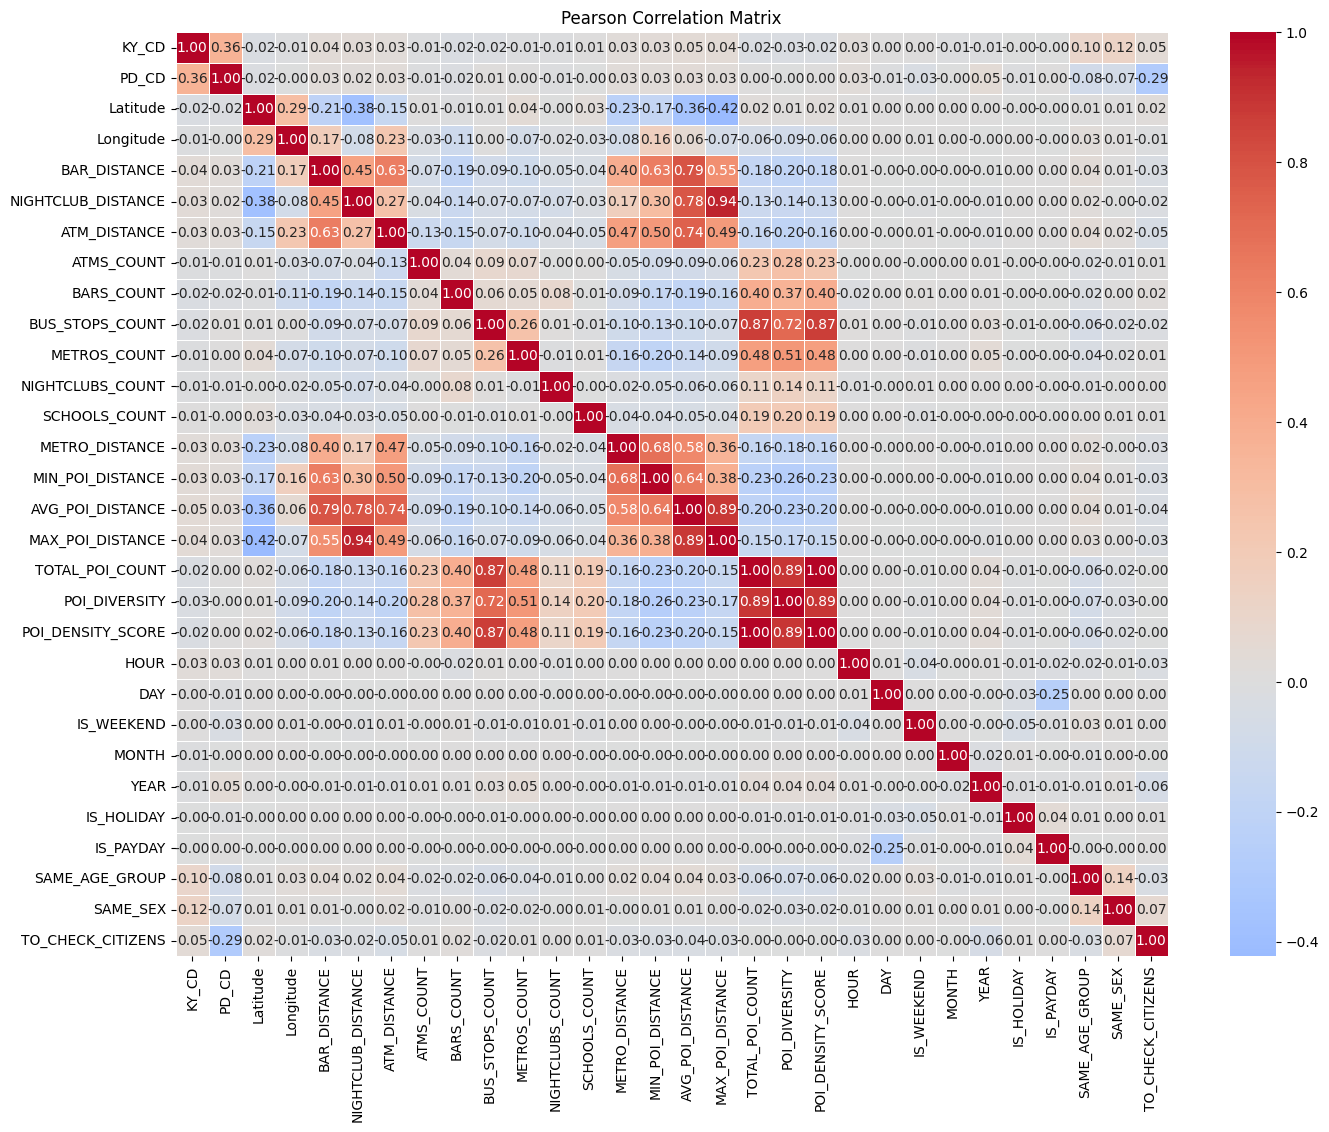

In [13]:
# Pearson correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr(method='pearson')

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Matrix')
plt.show()

# Final export

Pre-export checks warn on excessive missingness, tiny datasets, or extreme feature counts. We export CSV plus metadata (shape, dtypes, missing, memory, quality score) and an optional 10k sample for quick experiments.

In [14]:
print("\n=== FINAL DATASET EXPORT ===")

# Remove duplicates if any exist
if num_duplicates > 0:
    print(f"\nRemoving {num_duplicates} duplicate rows before export...")
    df_final = df.drop_duplicates()
    print(f"Dataset shape after deduplication: {df_final.shape}")
else:
    df_final = df.copy()

# Export in multiple formats
print("\n--- Exporting Final Dataset ---")

# Main CSV export
final_file_path = os.path.join(final_dir, 'final_crime_data.csv')
try:
    df_final.to_csv(final_file_path, index=False)
    file_size = os.path.getsize(final_file_path) / 1024**2
    print(f"Main dataset saved: {final_file_path} ({file_size:.2f} MB)")
except Exception as e:
    print(f"Error saving main dataset: {e}")
    raise RuntimeError(f"Failed to save final dataset: {e}")

# Compressed export for large datasets
if file_size > 100:  # If larger than 100MB
    compressed_file_path = os.path.join(final_dir, 'final_crime_data.csv.gz')
    try:
        df_final.to_csv(compressed_file_path, index=False, compression='gzip')
        compressed_size = os.path.getsize(compressed_file_path) / 1024**2
        compression_ratio = (1 - compressed_size/file_size) * 100
        print(f"Compressed dataset saved: {compressed_file_path} ({compressed_size:.2f} MB, {compression_ratio:.1f}% compression)")
    except Exception as e:
        print(f"Could not create compressed version: {e}")

# Export dataset metadata
metadata = {
    'export_timestamp': pd.Timestamp.now().isoformat(),
    'shape': df_final.shape,
    'columns': list(df_final.columns),
    'dtypes': df_final.dtypes.to_dict(),
    'missing_values': df_final.isnull().sum().to_dict(),
    'memory_usage_mb': df_final.memory_usage(deep=True).sum() / 1024**2
}

metadata_file_path = os.path.join(final_dir, 'final_dataset_metadata.json')
try:
    # Convert any non-serializable types to strings
    metadata_serializable = {}
    for key, value in metadata.items():
        if isinstance(value, dict):
            metadata_serializable[key] = {str(k): str(v) for k, v in value.items()}
        else:
            metadata_serializable[key] = str(value) if not isinstance(value, (str, int, float, bool, list)) else value

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_serializable, f, indent=2)
    print(f"Dataset metadata saved: {metadata_file_path}")
except Exception as e:
    print(f"Could not save metadata: {e}")

# Create a sample dataset for quick testing
if len(df_final) > 10000:
    sample_size = 10000
    df_sample = df_final.sample(n=sample_size, random_state=42)
    sample_file_path = os.path.join(final_dir, f'final_crime_data_sample_{sample_size}.csv')
    try:
        df_sample.to_csv(sample_file_path, index=False)
        sample_file_size = os.path.getsize(sample_file_path) / 1024**2
        print(f"Sample dataset saved: {sample_file_path} ({sample_file_size:.2f} MB)")
    except Exception as e:
        print(f"Could not create sample dataset: {e}")

print(f"\n--- Export Summary ---")
print(f"Final dataset shape: {df_final.shape}")
print(f"Total features: {len(df_final.columns)}")
print(f"Main export location: {final_file_path}")

print(f"\nDATASET EXPORT COMPLETED SUCCESSFULLY")
print(f"Dataset is ready for machine learning and analysis")


=== FINAL DATASET EXPORT ===

Removing 2907 duplicate rows before export...
Dataset shape after deduplication: (2493835, 44)

--- Exporting Final Dataset ---
Dataset shape after deduplication: (2493835, 44)

--- Exporting Final Dataset ---
Main dataset saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv (795.13 MB)
Main dataset saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv (795.13 MB)
Compressed dataset saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv.gz (51.05 MB, 93.6% compression)
Compressed dataset saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv.gz (51.05 MB, 93.6% compression)
Dataset metadata saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_dataset_metadata.json
Dataset metadata saved: c:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Final\final_dat